## 0F - Hyper parameters during training

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 27 April 2023

**Purpose**: Making explicit all hyperparameters that govern the training and result.

**Key take-away messages**: All hyper-parameters relevant for training are easily accessible for the user. A good understanding of how these parameters affect inference results is important in order to produce high-fidelity results.

### Code

In [ ]:
import numpy as np
import pylab as plt
import swyft
import torch
import pytorch_lightning as pl

We consider the simple problem of measuring the mean of a Gaussian that we started with.

In [ ]:
def get_samples(N):
    z = np.random.rand(N, 1)*2-1  # Uniform prior over [-1, 1]
    x = z + np.random.randn(N, 1)*0.2
    samples = swyft.Samples(x = x, z = z)
    return samples

Let's now see how to pass network hyperparameters to `swyft.SwyftModule`. Since Swyft builds on PyTorch, we can use PyTorch functionalities for optimization. In the example below, we use the standard Adam algorithm to perform optimization steps, starting with a given learning rate `lr`, that can be passed through `swyft.SwyftModule`. We can also choose a learning rate scheduler. In particular, we have choosen an exponential decay scheduler with parameter `gamma`, which decays the learning rate of each parameter group by `gamma` every epoch. We can turn on the flag `verbose` in order to see how the learnign rate changes:

In [ ]:
class Network(swyft.SwyftModule):
    def __init__(self, lr = 1e-3, gamma = 1.):
        super().__init__()
        self.optimizer_init = swyft.OptimizerInit(torch.optim.Adam, dict(lr = lr),
              torch.optim.lr_scheduler.ExponentialLR, dict(gamma = gamma, verbose=True))
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 1, varnames = 'z', hidden_features = 128)

    def forward(self, A, B):
        logratios = self.logratios(A['x'], B['z'])
        return logratios

In [ ]:
def run(N = 3000, max_epochs = 3, shuffle = False, batch_size = 32, lr = 1e-3, gamma = 1.):
    samples = get_samples(N)
    dm = swyft.SwyftDataModule(samples, fractions = [0.7, 0.2, 0.1], batch_size = batch_size, shuffle = shuffle)
    trainer = swyft.SwyftTrainer(accelerator = 'gpu', devices = 1, max_epochs = max_epochs, precision = 64)
    network = Network(lr = lr, gamma = gamma)
    trainer.fit(network, dm)
    test_result = trainer.test(network, dm)
    return test_result, network, trainer

Notice the printed learning rate decay.

In [ ]:
test_result, network, trainer = run(N = 2000, batch_size = 32, max_epochs = 3, lr = 1e-2, gamma = .1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 67.6 K
-----------------------------------------------------
67.6 K    Trainable params
0         Non-trainable params
67.6 K    Total params
0.541     Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-02.


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.5479664164290159
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In this chapter we will also briefly show how to pass PyTorch Lightning callbacks to `swyft.SwyftTrainer`. Callbacks support the training procedure with convenient, but not necessary, functionalities. In the following example, we will use a learning rate monitor (`LearningRateMonitor`), that automatically monitors and logs learning rate for learning rate schedulers during training, and an early stopping callback (`EarlyStopping`) that monitors a metric (in this case the validation loss `val_loss`) and stop the training when no improvement is observed on that metric for the amount of epochs specified by the `patience` parameter. 

In [ ]:
def run(N = 3000, max_epochs = 3, shuffle = False, batch_size = 32, lr = 1e-3, gamma = 1.):
    samples = get_samples(N)
    dm = swyft.SwyftDataModule(samples, fractions = [0.7, 0.2, 0.1], batch_size = batch_size, shuffle = shuffle)
    callbacks = [
        pl.callbacks.LearningRateMonitor(), # learning rate monitor
        pl.callbacks.EarlyStopping("val_loss", patience = 3, verbose=True), # early stopping
    ]
    trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = max_epochs, precision = 64, callbacks = callbacks)
    network = Network(lr = lr, gamma = gamma)
    trainer.fit(network, dm)
    test_result = trainer.test(network, dm)
    return test_result, network, trainer

In the following example, notice how, even having set `max_epochs = 100`, the `EarlyStopping` callback signal the trainer to stop the training earlier because the validation loss was not improving. This is an extremely useful tool to avoid overfitting the training dataset.

In [ ]:
test_result, network, trainer = run(N = 2000, batch_size = 32, max_epochs = 100, lr = 1e-2, gamma = .1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 67.6 K
-----------------------------------------------------
67.6 K    Trainable params
0         Non-trainable params
67.6 K    Total params
0.541     Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-02.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: -0.459


Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.119 >= min_delta = 0.0. New best score: -0.577


Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: -0.586


Adjusting learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -0.587


Adjusting learning rate of group 0 to 1.0000e-07.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.587


Adjusting learning rate of group 0 to 1.0000e-08.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.587


Adjusting learning rate of group 0 to 1.0000e-09.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.587


Adjusting learning rate of group 0 to 1.0000e-10.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.587


Adjusting learning rate of group 0 to 1.0000e-11.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-12.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-13.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: -0.587. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.5231177964276551
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 44it [00:00, ?it/s]

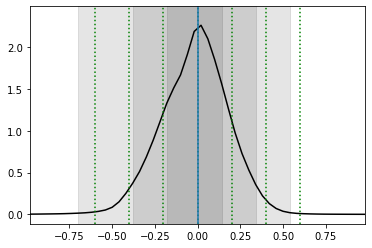

In [ ]:
x0 = 0.0
obs = swyft.Sample(x = np.array([x0]))
prior_samples = swyft.Samples(z = np.random.rand(10_000, 1)*2-1)
predictions = trainer.infer(network, obs, prior_samples)
contours = True
swyft.plot_1d(predictions, "z[0]", bins = 50, smooth = 1, contours = contours); contours = False
for offset in [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]:
    plt.axvline(x0+offset, color='g', ls = ':')
plt.axvline(x0);

### Exercises

1. Turn off the learning rate decay, and see how the posteriors look starting with different learning rates values, e.g. [1e-2, 1e-4, 1e-6]. How is the learning process affected by the learning rate?

In [ ]:
# Your results goes here

2. See what happens changing the early stopping patience.

In [ ]:
# Your results goes here